In [1]:
import os
import numpy as np

import torch

import cmapy
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

gpu = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER, SAVEFOLDER

In [2]:
src_domain = 'FSeg'
tgt_domain = 'SubF3'

# test
smooth = True

In [3]:
net = 'unet2d'
da_method = None

run_id = "iqilhh33"
run_name = "bs16-aug1-53"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATAPATH = os.path.join(DATAFOLDER, tgt_domain)

In [5]:
from models.unet import UNet2D
from models.dexined import DexiNed
from models.at_unet import AtrousUNet

In [6]:
filepath_weigths = os.path.join(SAVEFOLDER, '{}.pt'.format(run_id))

f = 16
ps = 128
stride = ps//2

## Load Data

In [7]:
m1, m2, m3 = 512,384,128

In [8]:
filename = os.path.join(DATAPATH, 'gxl.dat')

In [9]:
seismic = np.fromfile(filename, dtype=np.single)
seismic = np.reshape(seismic,(m1,m2,m3))
seismic.shape # IL, XL, Z

(512, 384, 128)

### Pre-Processing

In [10]:
# make it IL, Z, XL order
seismic = np.moveaxis(seismic,-2,-1) 
seismic.shape 

(512, 128, 384)

In [11]:
# new scaling (avoid division with zero values)
mean_ = seismic.mean()
std_ = seismic.std()

seismic = (seismic - mean_)/std_

### Patches Values

In [12]:
from dataloaders import PatchGenerator, DefaultGeneratorTest
from torch.utils.data import DataLoader

## Load Model

In [13]:
if net == "unet2d":
    model = UNet2D(f1=f).to(device)
elif net == "at-unet": 
    model = AtrousUNet(f1=f).to(device)
elif net == "dexined": 
    model = DexiNed(f1=f).to(device)
else:
    print("Error")

In [14]:
model.load_state_dict(torch.load(filepath_weigths))
model.eval()
print()

## Create inferences from generated patches 

In [15]:
from utils import *

In [16]:
def computeResults(test_loader, patch_generator, smooth=False):     

    test_predictions = []
    for images in test_loader:
        model.eval()
        y_preds = model(images.float().to(device))
        
        if net == "dexined":
            y_preds = (y_preds[-1] + y_preds[2] + y_preds[3])/3.
            y_preds = torch.nn.Sigmoid()(y_preds)
        
        test_predictions.extend(y_preds.detach().cpu())
        
    test_predictions = torch.stack(test_predictions).detach().cpu().numpy()
    test_predictions = np.moveaxis(test_predictions,-3,-1)
    
    if smooth:
        WINDOW_SPLINE_2D = window_2D(window_size=ps, power=2)
        test_predictions = np.array([patch * WINDOW_SPLINE_2D for patch in test_predictions])

    test_predictions = test_predictions.reshape((patch_generator.ny, patch_generator.nx, ps, ps, 1))
    
    return test_predictions

In [17]:
def reconstruct_F3block(seismic, how='iter_xl'):
    
    if how == 'iter_xl':
        h, w = seismic[0].shape
        n_sections = seismic.shape[0]
    else:
        h, w = seismic[:,:,0].T.shape
        n_sections = seismic.shape[2]
    
    patch_generator = PatchGenerator((h,w), ps, stride)
    
    y_prob_list = []
    # for idx in tqdm(range(n_sections)):
    for idx in range(n_sections):
        
        if how == 'iter_xl':
            seis = seismic[idx]
        else:
            seis = seismic[:,:,idx].T

        # generate patches
        X = patch_generator.get_patches(seis)
        X = np.expand_dims(X, 1)

        # load patches to data generator
        test_gen = DefaultGeneratorTest(X)
        test_loader = DataLoader(dataset=test_gen, batch_size=64, shuffle=False)

        # reconstruct crossline
        fault_probs = computeResults(test_loader, patch_generator, smooth=smooth)
        
        fault_probs = patch_generator.reconstruct_image(fault_probs) 
        fault_probs = np.squeeze(fault_probs)
        fault_probs = np.expand_dims(fault_probs, 0)

        y_prob_list.append(fault_probs)

    y_prob_total = np.vstack(y_prob_list)
    
    if how == 'iter_il':
        y_prob_total = np.transpose(y_prob_total, (2,1,0))
    
    return y_prob_total

### Crosslines

In [18]:
y_prob_total = reconstruct_F3block(seismic, how='iter_xl')
y_pred_total = np.where(y_prob_total >= 0.5, 1, 0)
y_pred_total.shape

nx, left_pad, right_pad, ny, top_pad, bottom_pad
7 64 64 2 32 32


(512, 128, 384)

In [19]:
ix = 30

# fig, axes = plt.subplots(1, 3, figsize=[21,12])

heatmap_img = cv2.applyColorMap((y_prob_total[ix]*255).astype(np.uint8), cmapy.cmap('jet_r'))

# axes[0].imshow(seismic[ix], cmap="gray")
# axes[0].axis('off')
# axes[1].imshow(heatmap_img, cmap='jet', interpolation='nearest')
# axes[1].axis('off')
# axes[2].imshow(y_pred_total[ix], cmap="jet", interpolation="nearest")
# axes[2].axis('off')



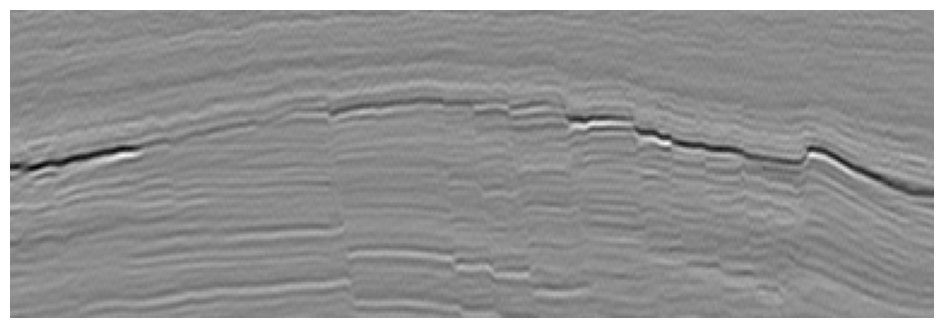

In [20]:
plt.figure(figsize=[16,4])

plt.imshow(seismic[ix], cmap="gray")
plt.axis('off')

# plt.savefig('../figures/resultsF3_xl30_input.pdf',
#             dpi=200, bbox_inches="tight")

plt.show()

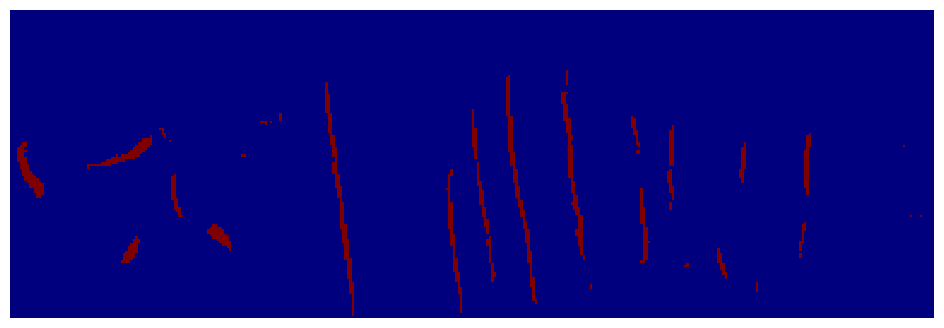

In [21]:
plt.figure(figsize=[16,4])

plt.imshow(y_pred_total[ix], cmap="jet", interpolation="nearest")
plt.axis('off')

# plt.savefig(f'../figures/resultsF3_xl30_{net}_{da_method}.pdf',
#             dpi=200, bbox_inches="tight")

plt.show()

(-0.5, 511.5, 127.5, -0.5)

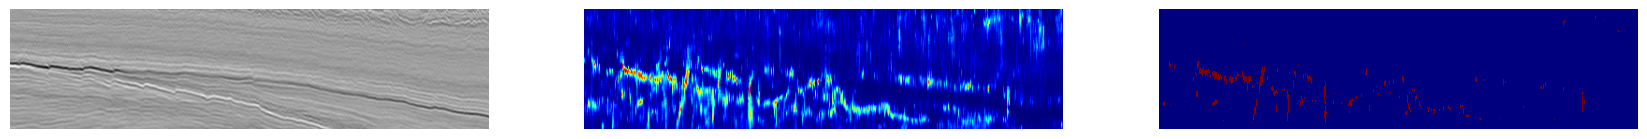

In [22]:
ix = 30

fig, axes = plt.subplots(1, 3, figsize=[21,12])

heatmap_img = cv2.applyColorMap((y_prob_total[:,:,ix].T*255).astype(np.uint8), cmapy.cmap('jet_r'))

axes[0].imshow(seismic[:,:,ix].T, cmap="gray")
axes[0].axis('off')
axes[1].imshow(heatmap_img)
axes[1].axis('off')
axes[2].imshow(y_pred_total[:,:,ix].T, cmap="jet", interpolation="nearest")
axes[2].axis('off')

(-0.5, 511.5, 383.5, -0.5)

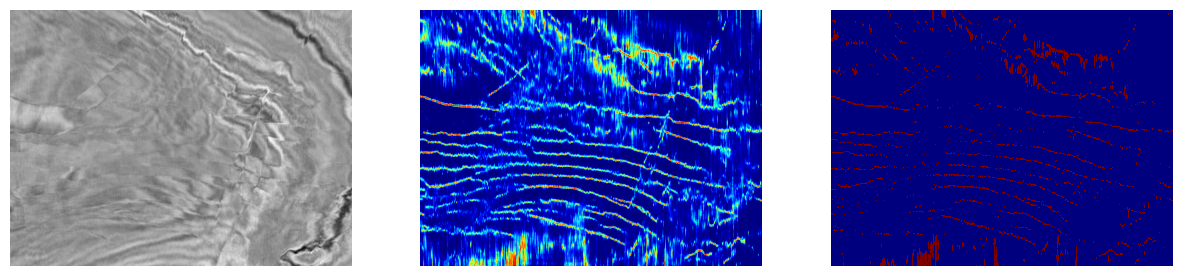

In [23]:
ix = 100

fig, axes = plt.subplots(1, 3, figsize=[15,8])

heatmap_img = cv2.applyColorMap((y_prob_total[:,ix].T*255).astype(np.uint8), cmapy.cmap('jet_r'))

axes[0].imshow(seismic[:,ix].T, cmap="gray")
axes[0].axis('off')
axes[1].imshow(heatmap_img/255, vmin=0.9)
axes[1].axis('off')
axes[2].imshow(y_pred_total[:,ix].T, cmap="jet", interpolation="nearest")
axes[2].axis('off')

In [24]:
y_prob_total2 = reconstruct_F3block(seismic, how='iter_il')
y_prob_total2.shape, y_prob_total2.mean(), y_prob_total2.std()

nx, left_pad, right_pad, ny, top_pad, bottom_pad
9 64 64 2 32 32


((512, 128, 384), 0.06559408526713463, 0.09575675064571224)

In [25]:
y_pred_total2 = np.where(y_prob_total2 >= 0.5, 1, 0)

(-0.5, 383.5, 127.5, -0.5)

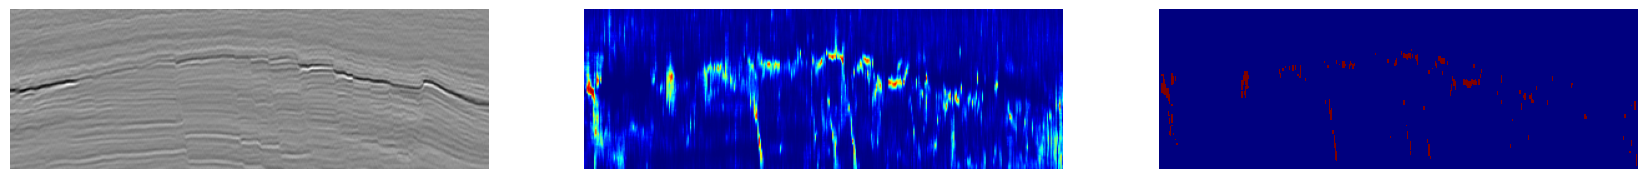

In [26]:
ix = 30

fig, axes = plt.subplots(1, 3, figsize=[21,12])

heatmap_img = cv2.applyColorMap((y_prob_total2[ix]*255).astype(np.uint8), cmapy.cmap('jet_r'))

axes[0].imshow(seismic[ix], cmap="gray")
axes[0].axis('off')
axes[1].imshow(heatmap_img)
axes[1].axis('off')
axes[2].imshow(y_pred_total2[ix], cmap="jet", interpolation="nearest")
axes[2].axis('off')

In [27]:
ix = 30

# fig, axes = plt.subplots(1, 3, figsize=[21,12])

heatmap_img = cv2.applyColorMap((y_prob_total2[:,:,ix].T*255).astype(np.uint8), cmapy.cmap('jet_r'))

# axes[0].imshow(seismic[:,:,ix].T, cmap="gray")
# axes[0].axis('off')
# axes[1].imshow(heatmap_img)
# axes[1].axis('off')
# axes[2].imshow(y_pred_total2[:,:,ix].T, cmap="jet", interpolation="nearest")
# axes[2].axis('off')


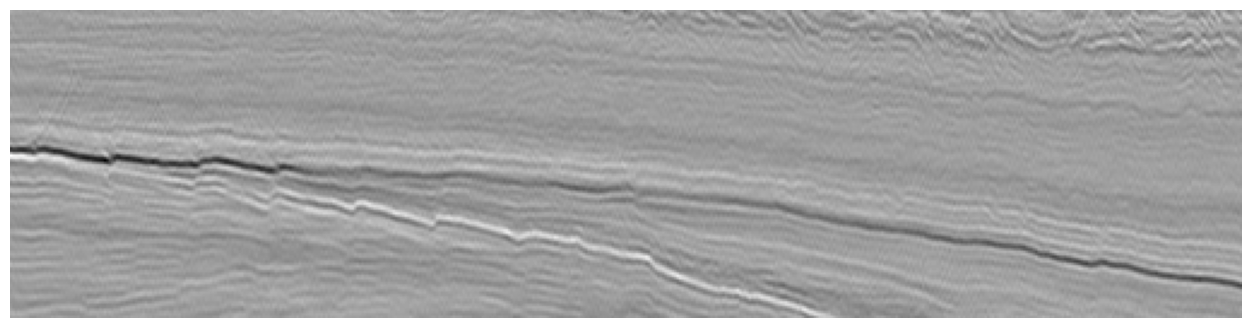

In [28]:
plt.figure(figsize=[16,4])

plt.imshow(seismic[:,:,ix].T, cmap="gray")
plt.axis('off')

# plt.savefig('../figures/resultsF3_il30_input.pdf',
#             dpi=200, bbox_inches="tight")

plt.show()

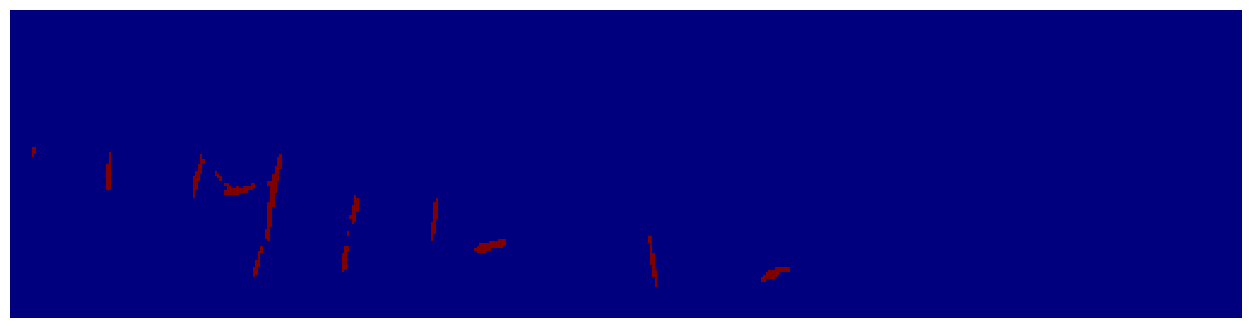

In [29]:
plt.figure(figsize=[16,4])

plt.imshow(y_pred_total2[:,:,ix].T, cmap="jet", interpolation="nearest")
plt.axis('off')

# plt.savefig(f'../figures/resultsF3_il30_{net}_{da_method}.pdf',
#             dpi=200, bbox_inches="tight")

plt.show()

(-0.5, 511.5, 383.5, -0.5)

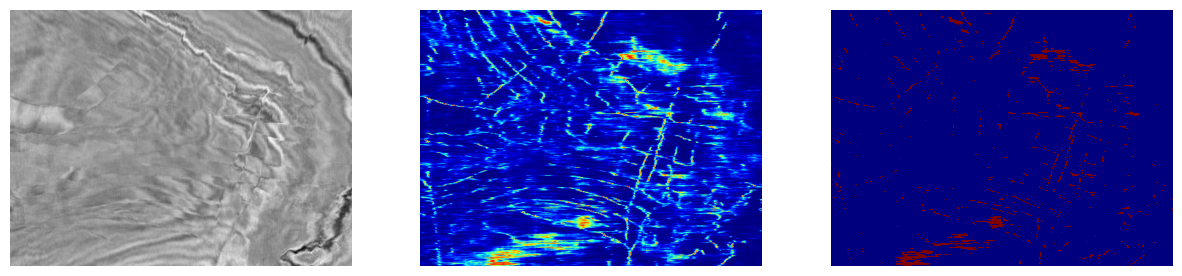

In [30]:
ix = 100

fig, axes = plt.subplots(1, 3, figsize=[15,8])

heatmap_img = cv2.applyColorMap((y_prob_total2[:,ix].T*255).astype(np.uint8), cmapy.cmap('jet_r'))

axes[0].imshow(seismic[:,ix].T, cmap="gray")
axes[0].axis('off')
axes[1].imshow(heatmap_img/255, vmin=0.4)
axes[1].axis('off')
axes[2].imshow(y_pred_total2[:,ix].T, cmap="jet", interpolation="nearest")
axes[2].axis('off')

### Merge

In [31]:
w = 1

y_prob_total3 = (y_prob_total*w + y_prob_total2)/(w+1)
y_pred_total3 = np.where(y_prob_total3 >= 0.5, 1, 0)

(-0.5, 383.5, 127.5, -0.5)

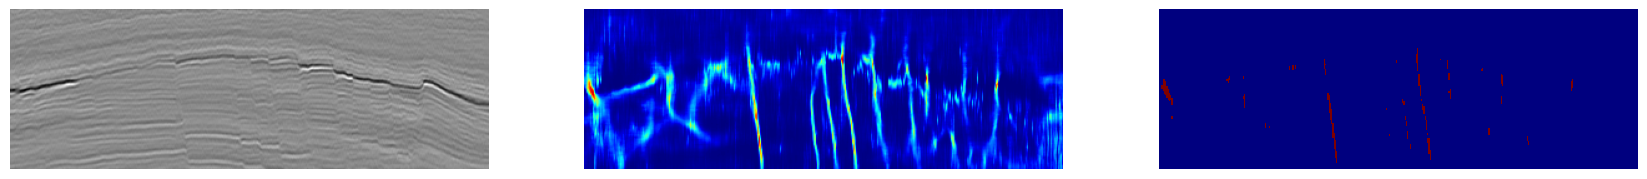

In [32]:
ix = 30

fig, axes = plt.subplots(1, 3, figsize=[21,12])

heatmap_img = cv2.applyColorMap((y_prob_total3[ix]*255).astype(np.uint8), cmapy.cmap('jet_r'))

axes[0].imshow(seismic[ix], cmap="gray")
axes[0].axis('off')
axes[1].imshow(heatmap_img)
axes[1].axis('off')
axes[2].imshow(y_pred_total3[ix], cmap="jet", interpolation="nearest")
axes[2].axis('off')


(-0.5, 511.5, 127.5, -0.5)

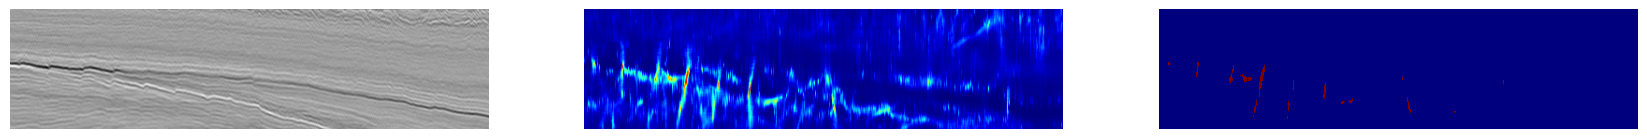

In [33]:
ix = 30

fig, axes = plt.subplots(1, 3, figsize=[21,12])

heatmap_img = cv2.applyColorMap((y_prob_total3[:,:,ix].T*255).astype(np.uint8), cmapy.cmap('jet_r'))

axes[0].imshow(seismic[:,:,ix].T, cmap="gray")
axes[0].axis('off')
axes[1].imshow(heatmap_img)
axes[1].axis('off')
axes[2].imshow(y_pred_total3[:,:,ix].T, cmap="jet", interpolation="nearest")
axes[2].axis('off')


(-0.5, 511.5, 383.5, -0.5)

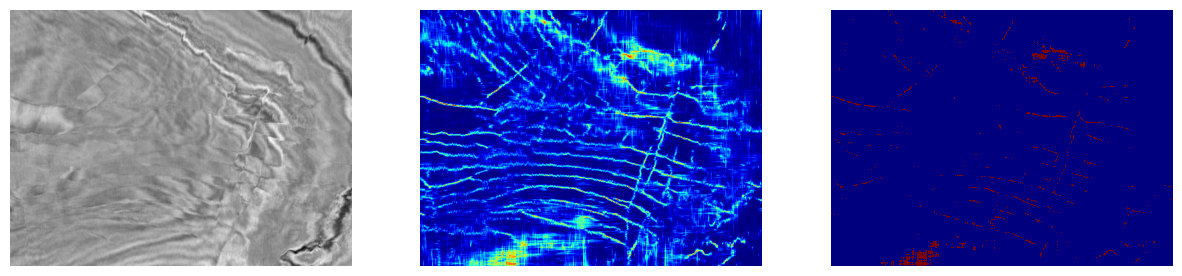

In [34]:
ix = 100

fig, axes = plt.subplots(1, 3, figsize=[15,8])

heatmap_img = cv2.applyColorMap((y_prob_total3[:,ix].T*255).astype(np.uint8), cmapy.cmap('jet_r'))

axes[0].imshow(seismic[:,ix].T, cmap="gray")
axes[0].axis('off')
axes[1].imshow(heatmap_img/255, vmin=0.4)
axes[1].axis('off')
axes[2].imshow(y_pred_total3[:,ix].T, cmap="jet", interpolation="nearest")
axes[2].axis('off')


### NRDD Format for Slicer 3D

In [35]:
nrdd_file = np.transpose(y_prob_total, (0,2,1)).astype(np.float32)
nrdd_file.shape, nrdd_file.dtype

((512, 384, 128), dtype('float32'))

In [36]:
# import itk
# image = itk.GetImageFromArray(nrdd_file)
# itk.imwrite(image, f'../figures/F3_{net}_{da_method}.nrrd')